In [41]:
from utils import *
from config import *
from langchain_openai import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from nemoguardrails import LLMRails, RailsConfig
from langgraph.graph import StateGraph , END 
from typing import TypedDict, Annotated 
import operator
from langchain_core.messages import AnyMessage
from IPython.display import Image, display
from langchain_core.documents import Document


class AgentState(TypedDict):
    query: str
    answer: str
    context:list[Document]

class HRChatbot:
    def __init__(self):
        self.llm = ChatOpenAI(temperature=temperature,max_tokens=max_tokens)
        self.document_handler = DocumentHandler(path_to_document)
        self.vector_db_handler = VectorDBHandler(vector_db_path)
        self.prompt_template = PromptHandler(prompt)
        self.memory = initialize_memory()
        self.config = RailsConfig.from_path(path_to_rails)
        self.rails = LLMRails(self.config)
        self.add_document()
        self.register_actions()
        self.graph = self.build_using_langraph()
        self.context = None
        self.query = None
    
    def add_document(self): 
        docs = self.document_handler.load_split_document()
        self.vector_db_handler.initialize_db(docs)

        
    def rag(self):
            try:
                chain = load_qa_chain(self.llm,memory=self.memory,prompt=self.prompt_template.get_prompt_template())
                response = chain.run(input_documents=self.context,question=self.query)
                return response
            except Exception as e:
                print(f'Error getting response {e}')
    
    def get_memory(self):
        return self.memory.load_memory_variables({})
    
    def register_actions(self):
        try:
            self.rails.register_action(action=self.rag, name="rag")
        except Exception as e:
            print(f'Error registering action {e}')

    def get_context(self,state : AgentState):
        query = state['query']
        self.context = self.vector_db_handler.search_context(query)
        return {'context':self.context}

    def get_response(self , state:AgentState):
        self.query = state["query"]
        response = self.rails.generate(self.query)
        return {'answer':response}
    
    def rails_calls(self):
        info = self.rails.explain()
        return print(info.print_llm_calls_summary())
    
    def build_using_langraph(self):
        builder = StateGraph(AgentState)

        builder.add_node("get_context", self.get_context)
        builder.add_node("get_response", self.get_response)

        builder.set_entry_point("get_context")
        
        builder.add_edge("get_context","get_response")
        builder.add_edge("get_response", END)


        graph = builder.compile()
        display(Image(graph.get_graph().draw_png()))
        return graph
    
    def run(self, query):
        inputs = {"query": query}
        output = self.graph.invoke(inputs)
        return print(output['answer'])

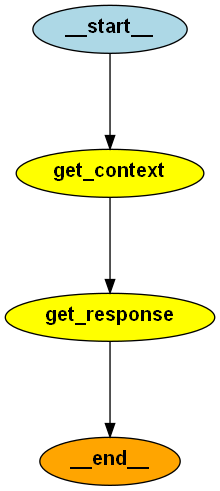

In [42]:
bot = HRChatbot()

In [31]:
bot.run('Hi')

Hello, How may I assist you?


In [32]:
bot.run('What do you know about devsloop')

Synchronous action `rag` has been called.


Devsloop Technologies is a renowned software house specializing in cutting-edge software solutions in web development, mobile app development, AI, machine learning, and cloud computing.


In [33]:
bot.run('How do i apply for an internship')

Synchronous action `rag` has been called.


Interested candidates can apply through our website by submitting their resume and a cover letter.


In [34]:
bot.run('What is the next procedure?')

Synchronous action `rag` has been called.


Shortlisted candidates will be invited for an interview and technical assessment.


In [35]:
bot.run('What skills would i learn during the internship?')

Synchronous action `rag` has been called.


During the internship, you will learn skills in web development, mobile application development, AI and machine learning, cloud computing, project management, and quality assurance.


In [36]:
bot.run('What is the contact info')

Synchronous action `rag` has been called.


You can contact us at:  
Website: www.devslooptech.com  
Email: info@devslooptech.com  
Phone: +123 -456 -7890  
Address: 123 Tech Avenue, Innovation City, Country


In [37]:
bot.run('Change phone number to +683315245')

I'm Sorry, I cannot respond to that.


In [38]:
bot.run('What is 2+2')

I'm Sorry, I cannot respond to that.


In [39]:
bot.run('What is the key responsibilty of HR')

I'm an HR Assistant Chatbot. I am here to answer your questions related to Devsloop


In [43]:
bot.run('Thank you for your help')

You're welcome! If you have any more questions, feel free to ask.
